### The influence of tides in TNBD and DITD Mooring Data 2018 - 2019 

In [1]:
import xarray as xr 
import numpy as np  
import matplotlib.pyplot as plt
import xrft 
import cmocean
import scipy

In [2]:
# load velocity data 
tnbd_vel1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/vel_1100.nc')
# load sbe data 
tnbd_sbe1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/sbe_1100.nc')

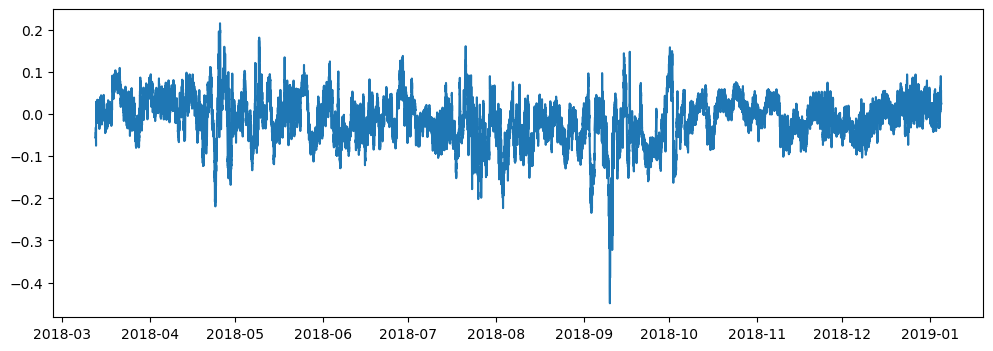

In [3]:
# plot a time series of the velocity data 
fig = plt.figure(figsize=(12,4))
plt.plot(tnbd_vel1100.time,tnbd_vel1100.east)

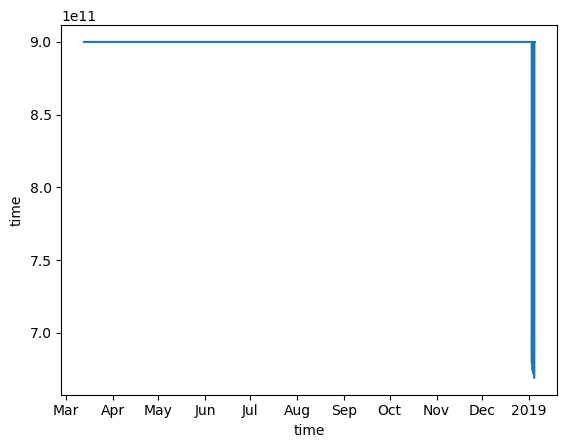

In [4]:
# we need to remove the end of the data because dt gets messed up 
tnbd_vel1100.time.diff('time').plot()

In [93]:
tnbd_vel1100 = tnbd_vel1100.sel(time=slice('2018-03','2019-01-02'))
tnbd_sbe1100 = tnbd_sbe1100.sel(time=slice('2018-03','2019-01-02'))

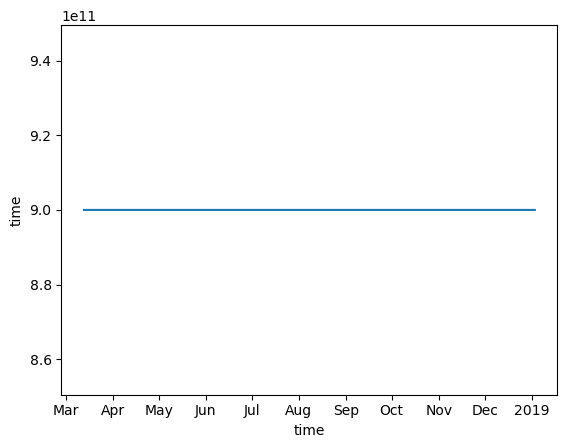

In [20]:
# dt is now the same 
tnbd_vel1100.east.time.diff('time').plot()

In [21]:
# we can see that we have an even number of datapoints - good for FFT 
tnbd_vel1100.east

<xarray.DataArray 'east' (time: 28416)> Size: 227kB
array([-0.045259, -0.057418, -0.051127, ...,  0.033375,  0.03174 ,  0.022429])
Coordinates:
    index    (time) int64 227kB ...
  * time     (time) datetime64[ns] 227kB 2018-03-13 ... 2019-01-02T23:45:00

### Spectra using XRFT 

In [22]:
# detrend data 
east_detrended= xrft.detrend(tnbd_vel1100.east, dim='time')

In [23]:
east_detrended.time

<xarray.DataArray 'time' (time: 28416)> Size: 227kB
array(['2018-03-13T00:00:00.000000000', '2018-03-13T00:15:00.000000000',
       '2018-03-13T00:30:00.000000000', ..., '2019-01-02T23:15:00.000000000',
       '2019-01-02T23:30:00.000000000', '2019-01-02T23:45:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    index    (time) int64 227kB ...
  * time     (time) datetime64[ns] 227kB 2018-03-13 ... 2019-01-02T23:45:00

In [25]:
spectra = xrft.power_spectrum(da=east_detrended.drop(['index']),dim='time')

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_11444/2764362177.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  spectra = xrft.power_spectrum(da=east_detrended.drop(['index']),dim='time')


In [33]:
spectra = spectra.where(spectra.freq_time > 0, drop=True)

In [41]:
tnbd_vel1100.east.time

<xarray.DataArray 'time' (time: 28416)> Size: 227kB
array(['2018-03-13T00:00:00.000000000', '2018-03-13T00:15:00.000000000',
       '2018-03-13T00:30:00.000000000', ..., '2019-01-02T23:15:00.000000000',
       '2019-01-02T23:30:00.000000000', '2019-01-02T23:45:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    index    (time) int64 227kB ...
  * time     (time) datetime64[ns] 227kB 2018-03-13 ... 2019-01-02T23:45:00

In [43]:
sampling_rate = 1/15  # 1/minutes 
nyquist = sampling_rate / 2

In [44]:
nyquist

0.03333333333333333

In [45]:
spectra.freq_time.max()

<xarray.DataArray 'freq_time' ()> Size: 8B
array(0.00055552)

In [40]:
# nyquist freq is sampling rate / 2
tnbd_vel1100.east.time.diff(dim='time')

<xarray.DataArray 'time' (time: 28415)> Size: 227kB
array([900000000000, 900000000000, 900000000000, ..., 900000000000,
       900000000000, 900000000000], dtype='timedelta64[ns]')
Coordinates:
    index    (time) int64 227kB ...
  * time     (time) datetime64[ns] 227kB 2018-03-13T00:15:00 ... 2019-01-02T2...

Text(0.5, 0, 'Frequency [1/hr]')

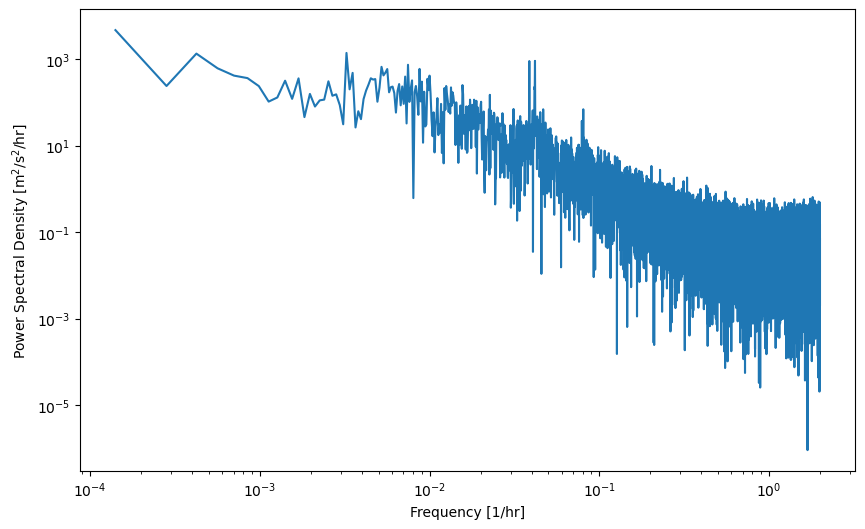

In [51]:
fig = plt.figure(figsize=(10,6))
plt.loglog(spectra.freq_time*3600,spectra)
plt.ylabel(r'Power Spectral Density [m$^2$/s$^2$/hr]')
plt.xlabel('Frequency [1/hr]')

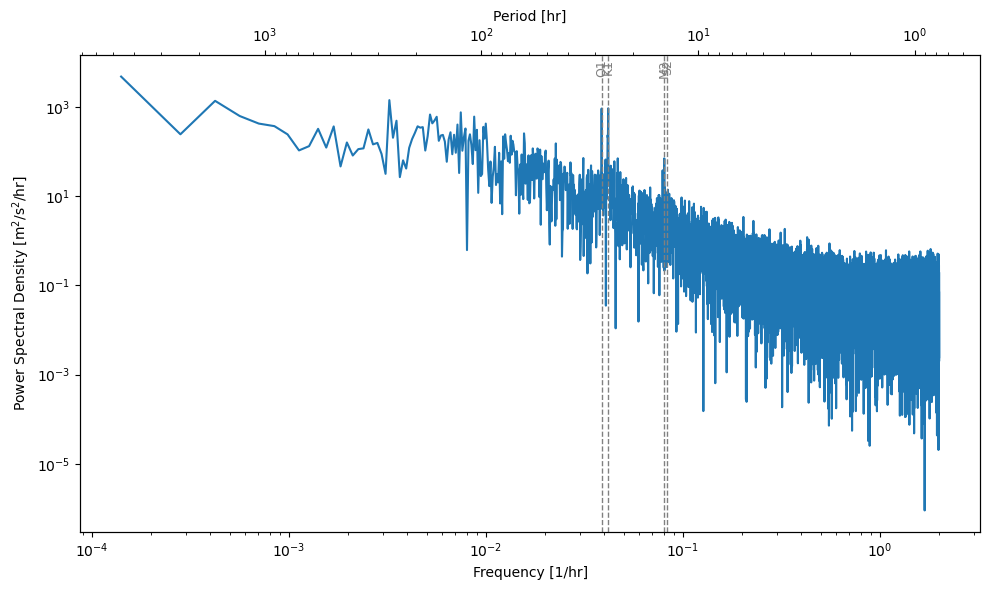

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Frequency and PSD (assumed given)
freq = spectra.freq_time * 3600  # Frequency in 1/hr
psd = spectra

# Create base plot
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(freq, psd, label='PSD')
ax.set_xlabel('Frequency [1/hr]')
ax.set_ylabel(r'Power Spectral Density [m$^2$/s$^2$/hr]')

# Add vertical shaded regions for tidal peaks
tidal_peaks = {
    'M2': 0.0805,
    'S2': 0.0833,
    'K1': 0.0418,
    'O1': 0.0387
}
# peak_width = 0.002  # Width of shaded region

# for name, f in tidal_peaks.items():
#     ax.axvspan(f - peak_width, f + peak_width, color='gray', alpha=0.3)
#     ax.text(f, ax.get_ylim()[1]*0.8, name, rotation=90,
#             ha='center', va='top', fontsize=9, color='gray')

for name, f in tidal_peaks.items():
    ax.axvline(f, color='gray', linestyle='--', linewidth=1)
    ax.text(f, ax.get_ylim()[1]*0.8, name, rotation=90,
            ha='center', va='top', fontsize=9, color='gray')
    
# Create top x-axis with period
ax_top = ax.twiny()
ax_top.set_xscale('log')

freq_limits = ax.get_xlim()
freq_limits = [spectra.freq_time[0]*3600, spectra.freq_time[-1]*3600]
period_limits = [1/freq_limits[0], 1/freq_limits[1]]
ax_top.set_xlim(period_limits)
ax_top.set_xlabel('Period [hr]')
ax_top.xaxis.set_ticks_position('top')
ax_top.xaxis.set_label_position('top')
# ax_top.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()


### Filter out tides 

In [57]:
sampling_hours = 0.25  # adjust this if different
window_days = 3
window_size = int(window_days * 24 / sampling_hours)


In [58]:
window_size

288

In [59]:
if window_size % 2 == 0:
    window_size += 1

In [60]:
from scipy.signal import windows
import numpy as np

cosine_window = windows.cosine(window_size)
cosine_window /= cosine_window.sum()  # normalize so it acts like a moving average


In [62]:
len(cosine_window)

289

In [63]:
import xarray as xr

# assume velocity_da is your DataArray with dimension "time"
cosine_weights = xr.DataArray(cosine_window, dims="window")

# create rolling window and apply weights
filtered_velocity = (
    tnbd_vel1100.east
    .rolling(time=window_size, center=True)
    .construct("window")
    .dot(cosine_weights)
)


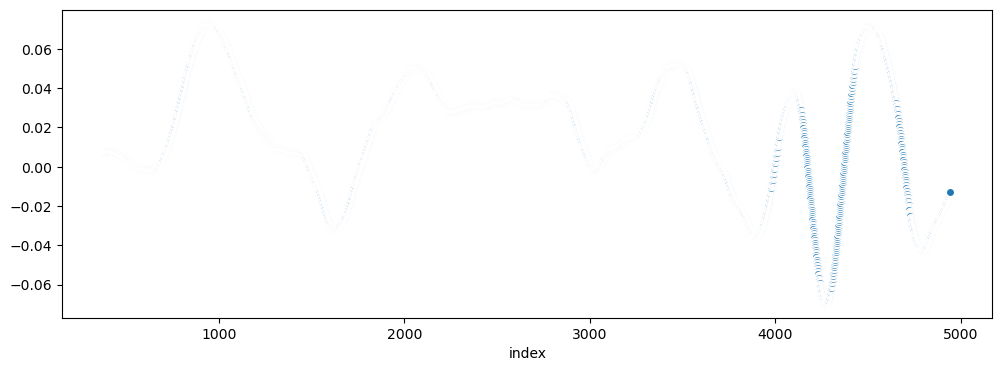

In [77]:
filtered_velocity.sel(time=slice('2018-03','2018-04')).plot.scatter(figsize=(12,4))
# tnbd_vel1100.east.plot()

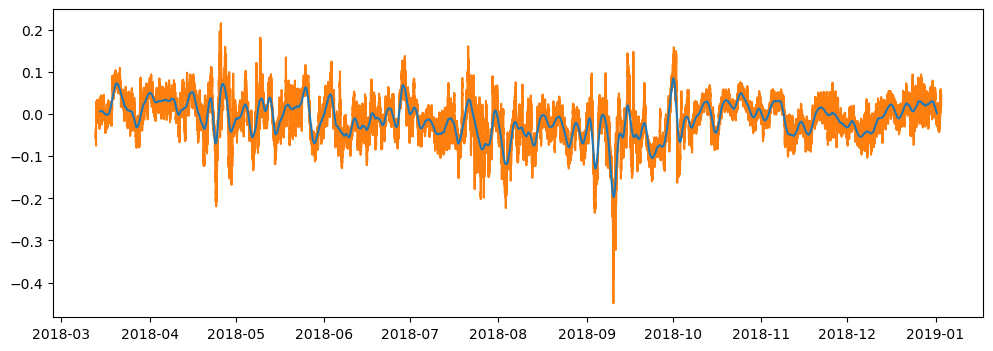

In [86]:
fig = plt.figure(figsize=(12,4))
plt.plot(tnbd_vel1100.time,tnbd_vel1100.east,color='tab:orange')
plt.plot(filtered_velocity.time,filtered_velocity)


In [96]:
sal = tnbd_sbe1100.resample(time='15MIN').mean().practical_salinity

/opt/anaconda3/envs/TNB/lib/python3.10/site-packages/xarray/groupers.py:513: FutureWarning: 'MIN' is deprecated and will be removed in a future version, please use 'min' instead.
  self.index_grouper = pd.Grouper(


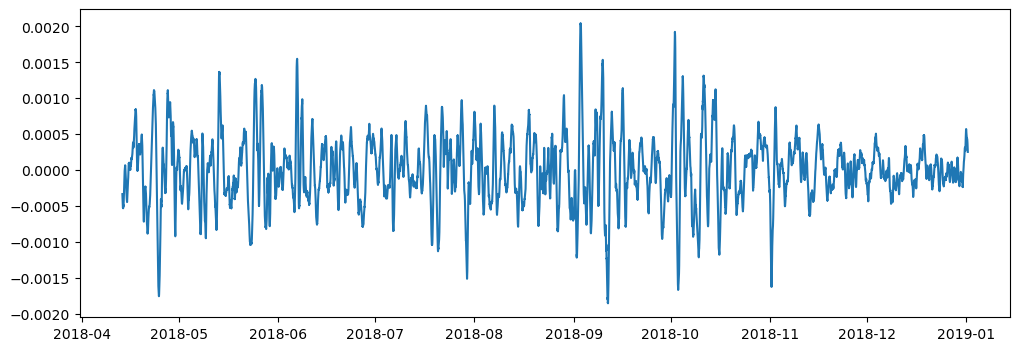

In [91]:
fig = plt.figure(figsize=(12,4))
plt.plot(tidal.rolling(time=2880).mean().time,tidal.rolling(time=2880).mean())
plt.plot(tnbd_sbe1100.rolling(time=

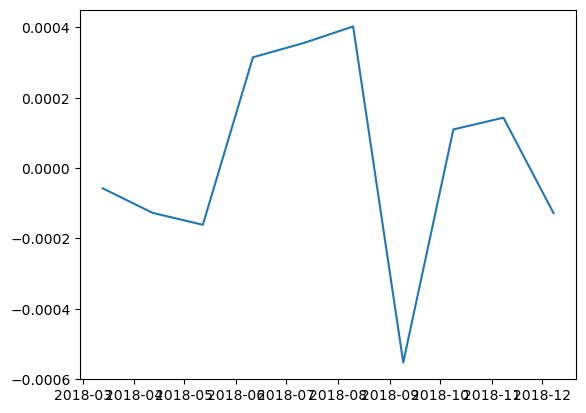

In [88]:
plt.plot(tidal.resample(time='30D').mean().time,tidal.resample(time='30D').mean())

In [71]:
tidal = tnbd_vel1100.east - filtered_velocity 

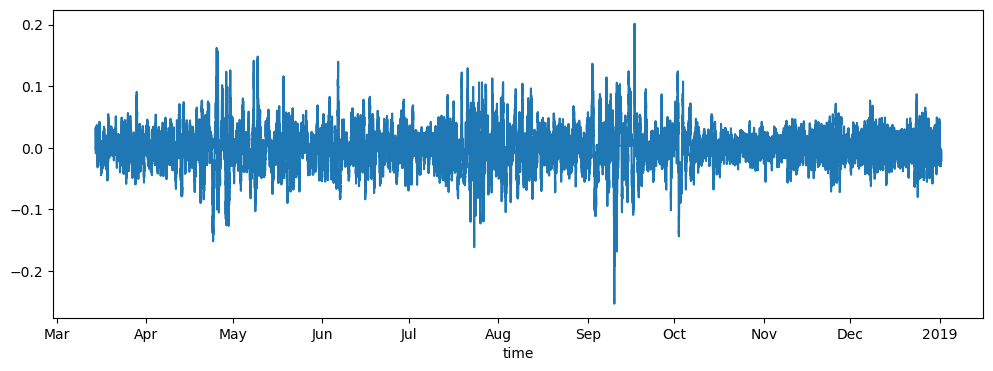

In [73]:
tidal.plot(figsize=(12,4))

In [65]:
tnbd_vel1100.east

<xarray.DataArray 'east' (time: 28416)> Size: 227kB
array([-0.045259, -0.057418, -0.051127, ...,  0.033375,  0.03174 ,  0.022429])
Coordinates:
    index    (time) int64 227kB ...
  * time     (time) datetime64[ns] 227kB 2018-03-13 ... 2019-01-02T23:45:00

In [8]:
# we need to detrend before taking FFT 
east_detrend = scipy.signal.detrend(east)

In [38]:
scipy.signal.detrend?

Signature:
scipy.signal.detrend(
    data,
    axis=-1,
    type='linear',
    bp=0,
    overwrite_data=False,
)
Docstring:
Remove linear trend along axis from data.

Parameters
----------
data : array_like
    The input data.
axis : int, optional
    The axis along which to detrend the data. By default this is the
    last axis (-1).
type : {'linear', 'constant'}, optional
    The type of detrending. If ``type == 'linear'`` (default),
    the result of a linear least-squares fit to `data` is subtracted
    from `data`.
    If ``type == 'constant'``, only the mean of `data` is subtracted.
bp : array_like of ints, optional
    A sequence of break points. If given, an individual linear fit is
    performed for each part of `data` between two break points.
    Break points are specified as indices into `data`. This parameter
    only has an effect when ``type == 'linear'``.
overwrite_data : bool, optional
    If True, perform in place detrending and avoid a copy. Default is False

Returns

In [9]:
east_detrend

array([-0.04479367, -0.05695182, -0.05066   , ...,  0.05732868,
        0.05569407,  0.0463838 ])

Text(0, 0.5, 'Velocity [m/s]')

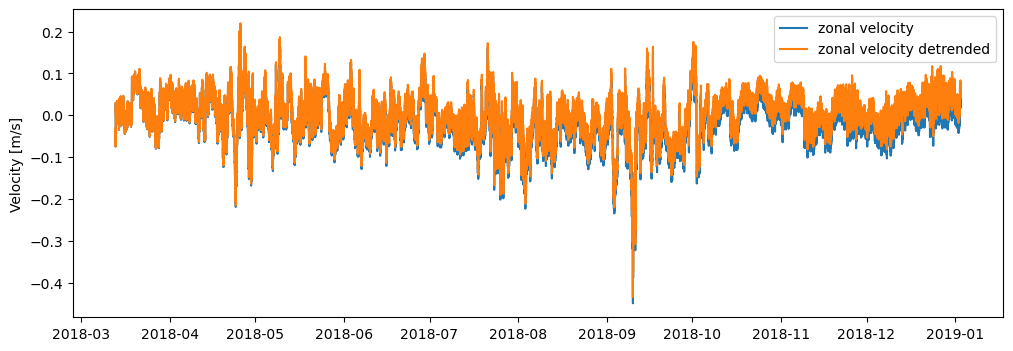

In [10]:
fig = plt.figure(figsize=(12,4))
plt.plot(east.time,east,label='zonal velocity')
plt.plot(east.time,east_detrend,label='zonal velocity detrended')
plt.legend()
plt.ylabel('Velocity [m/s]')

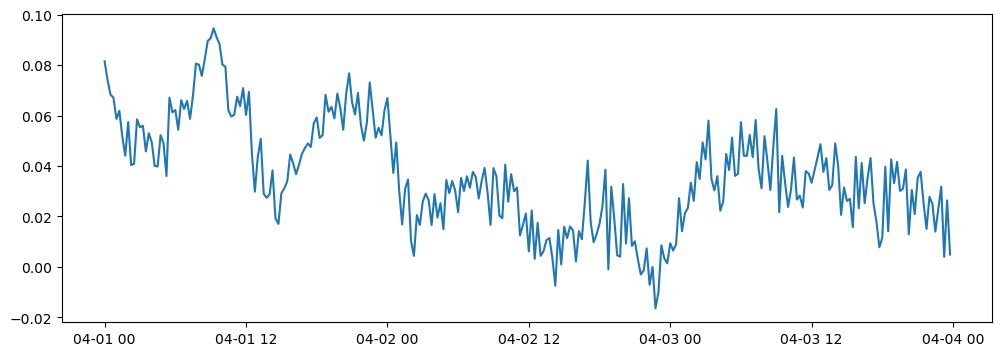

In [12]:
# select a few days of data to see if tidal signals are evident 
fig = plt.figure(figsize=(12,4))
plt.plot(east.sel(time=slice('2018-04-01','2018-04-03')).time,east.sel(time=slice('2018-04-01','2018-04-03')),label='zonal velocity')

### FFT Analysis via numpy 

In [40]:
fh = scipy.fft.rfft(east_detrend)

In [41]:
freq = scipy.fft.rfftfreq(n=len(east_detrend),d=15)

In [43]:
len(freq)

14209

In [44]:
len(fh)

14209

/opt/anaconda3/envs/oceandynamics/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


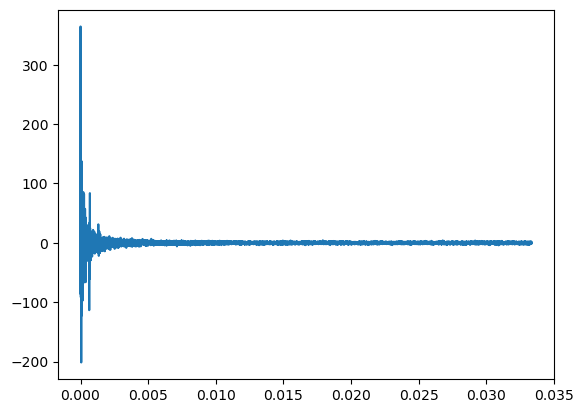

In [45]:
plt.plot(freq,fh)

In [46]:
magnitude_spectrum = np.abs(fh)

In [48]:
len(magnitude_spectrum )

14209

(0.001, 10000.0)

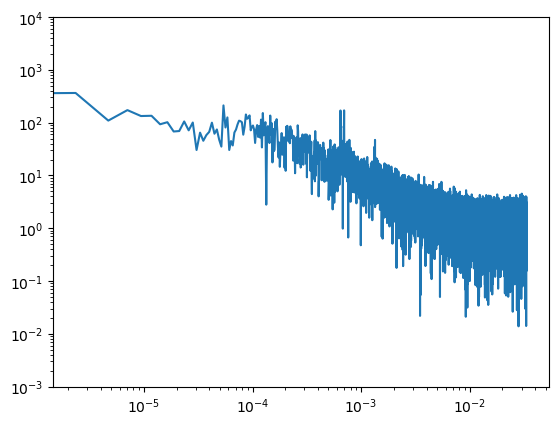

In [83]:
plt.loglog(freq,magnitude_spectrum)
# plt.xlim(-0.00001,0.005)
plt.ylim(10e-4,10e3)

In [54]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [55]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/15
lowcut = 0.0006
highcut = 0.0008


In [57]:
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

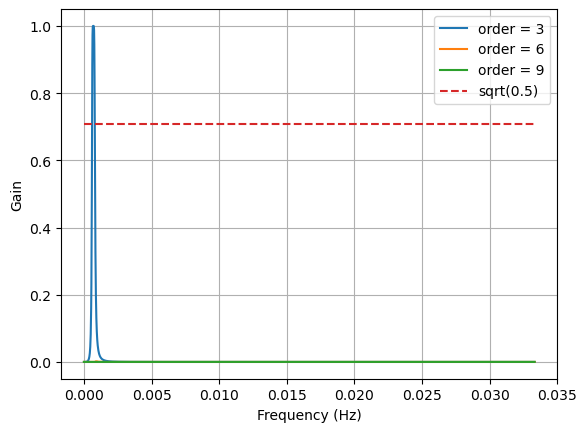

In [58]:
# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [59]:
y = butter_bandpass_filter(east_detrend, lowcut, highcut, fs, order=3)

In [71]:
y

array([-3.68029161e-08, -2.65754611e-07, -9.69070453e-07, ...,
        1.08600076e-02,  1.07535625e-02,  1.05869719e-02])

In [75]:
east_detrend[0:30]

array([-0.04479367, -0.05695182, -0.05066   , -0.03110021, -0.04329592,
       -0.05650989, -0.053326  , -0.06265822, -0.06094682, -0.07097771,
       -0.07439805,  0.02372985,  0.02203571,  0.00966143,  0.02456567,
        0.03001781,  0.00999909,  0.02094646,  0.02733537,  0.01012062,
        0.01179446,  0.01302968, -0.00295068,  0.00172765,  0.01898162,
        0.0074031 ,  0.00579044,  0.00634893,  0.01156298,  0.00814264])

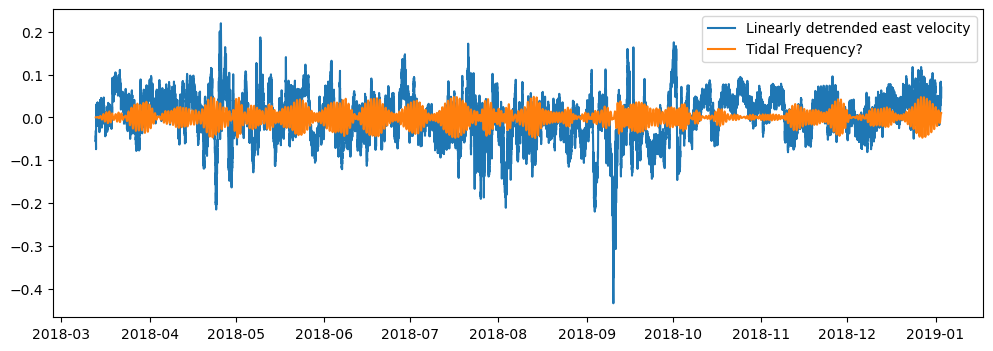

In [80]:
fig = plt.figure(figsize=(12,4))
plt.plot(east.time,east_detrend,label='Linearly detrended east velocity')
plt.plot(east.time,y,label='Tidal Frequency?')
# plt.plot(east.isel(time=slice(0,1000)).time,(east_detrend - y)[0:1000],label='velocity - tidal frequency')
plt.legend()

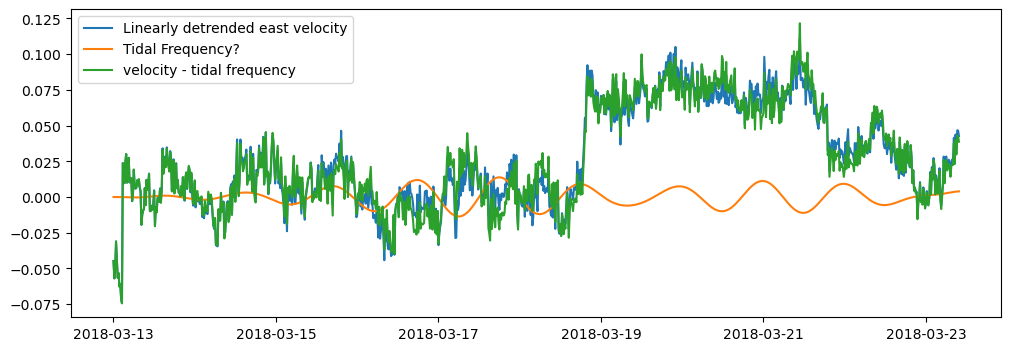

In [79]:
fig = plt.figure(figsize=(12,4))
plt.plot(east.isel(time=slice(0,1000)).time,east_detrend[0:1000],label='Linearly detrended east velocity')
plt.plot(east.isel(time=slice(0,1000)).time,y[0:1000],label='Tidal Frequency?')
plt.plot(east.isel(time=slice(0,1000)).time,(east_detrend - y)[0:1000],label='velocity - tidal frequency')
plt.legend()

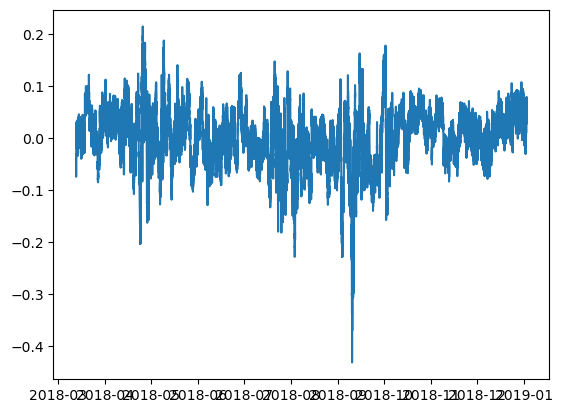

In [67]:
plt.plot(east.time,(east_detrend - y))

In [44]:
# east.time.diff(dim='time')[0].values.astype('float64')

900000000000.0

In [14]:
inverse_sample_rate = 1/east.time.diff(dim='time')[0].values.astype('float64')

In [15]:
inverse_sample_rate

1.1111111111111112e-12

In [16]:
fh = np.fft.rfft(east_detrend)

In [35]:
len(fh.real)

14209

In [19]:
#If n is even, the length of the transformed axis is (n/2)+1
len(fh)

14209

In [23]:
dt = 15
N = len(east_detrend)
scale = 1/(N*dt)

In [24]:
N*dt

426240

In [25]:
scale

2.346096096096096e-06

In [27]:
delta_f = scale 

In [28]:
freq = delta_f * np.arange(N)

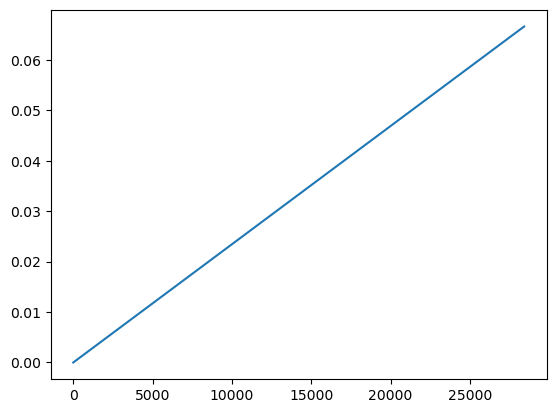

In [30]:
plt.plot(freq)

In [31]:
# only positive 
freq_pos = delta_f * np.arange(((N/2)+1))

In [36]:
len(freq_pos)

14209

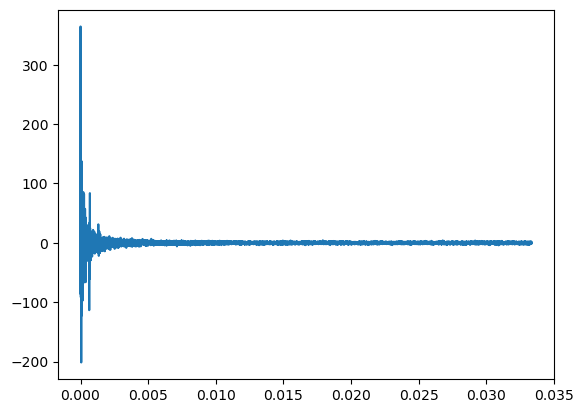

In [37]:
plt.plot(freq_pos,fh.real)

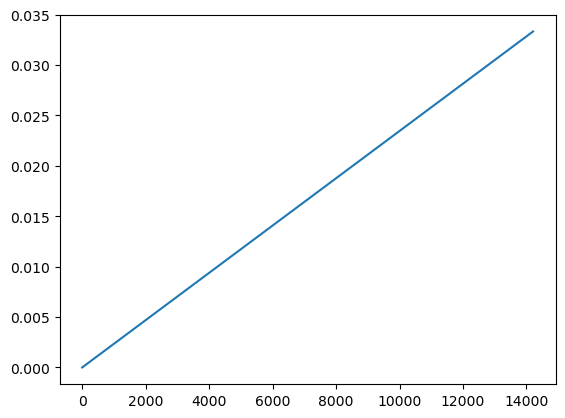

In [32]:
plt.plot(freq_pos)

In [ ]:
fh = 

In [26]:
freq*scale

NameError: name 'freq' is not defined

In [98]:
# calculate frequencies associated with rfft 
freq = np.fft.rfftfreq(n=len(east_detrend),d=1/15)

In [99]:
# length matches that of fft 
len(freq)

14209

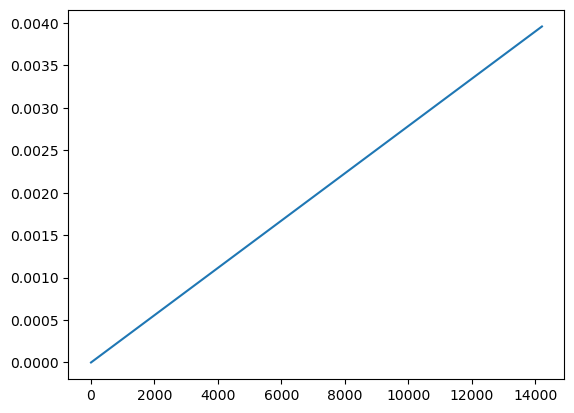

In [100]:
plt.plot(freq*scale)

In [101]:
(freq*scale).max()

0.0039590371621621625

In [102]:
(freq*scale).min()

0.0

In [70]:
time_strings = east.time.values

In [71]:
time_strings

array(['2018-03-13T00:00:00.000000000', '2018-03-13T00:15:00.000000000',
       '2018-03-13T00:30:00.000000000', ...,
       '2019-01-02T23:15:00.000000000', '2019-01-02T23:30:00.000000000',
       '2019-01-02T23:45:00.000000000'], dtype='datetime64[ns]')

In [72]:
T = (time_strings[-1] - time_strings[0]).astype('timedelta64[m]')

In [73]:
T

numpy.timedelta64(426225,'m')

In [74]:
T = 426225  #minutes 

In [75]:
delta_t = 15   # minutes 

In [76]:
sample_intervals = T/delta_t

In [77]:
sample_intervals

28415.0

In [78]:
# sample points 
N = sample_intervals + 1 

In [79]:
N

28416.0

In [80]:
nyquist_freq = 1/(2*delta_t)

In [81]:
nyquist_freq

0.03333333333333333

In [82]:
(sample_intervals/2)/(sample_intervals*delta_t)

0.03333333333333333

In [83]:
# our max freq is nyquist frequency 
# our min freq is 1/Time_length 
1/T

2.3461786615050735e-06

In [84]:
freq

array([0.00000000e+00, 5.27871622e-04, 1.05574324e-03, ...,
       7.49894426e+00, 7.49947213e+00, 7.50000000e+00])

In [31]:
N = len(east_detrend)
dt = 1/15
# define scaling factor 
scale = 1/(N*dt)

In [32]:
# get spectrum by taking the real part of FFT 
spec = 2*(fh*fh.conj()).real / scale / N**2

# account for zeroth frequency 
spec[0] = spec[0]/2

In [33]:
len(spec)

14209

In [13]:
plt.plot(freq*sacle,spec)

NameError: name 'freq' is not defined

In [163]:
u_dft = xrft.dft(east, true_phase=True, true_amplitude=True, detrend='constant',window='hamming')

/opt/anaconda3/envs/oceandynamics/lib/python3.10/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


In [164]:
u_dft_real = u_dft.real.where(u_dft.real > 0, drop=True)
# u_dft_real = u_dft.real.where(u_dft.real > 0, drop=True)

In [165]:
u_dft_real = u_dft_real.where(u_dft.freq_time > 0, drop=True)

In [166]:
u_dft_real['freq_time'] = u_dft_real.freq_time*(60/1)

In [167]:
u_dft_real

<xarray.DataArray (freq_time: 7145)>
array([124165.88396845,  22719.19210515,   8450.41280674, ...,
          228.29785624,   1032.38976226,    202.8042837 ])
Coordinates:
  * freq_time  (freq_time) float64 2.346e-06 4.692e-06 ... 0.03332 0.03333

(0.0, 0.005)

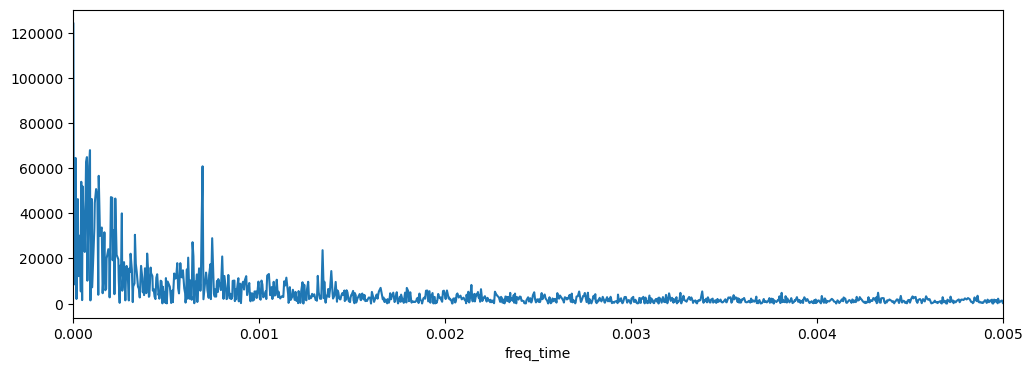

In [170]:
fig = plt.figure(figsize=(12,4))
(u_dft_real).plot()
plt.xlim(0,0.005)

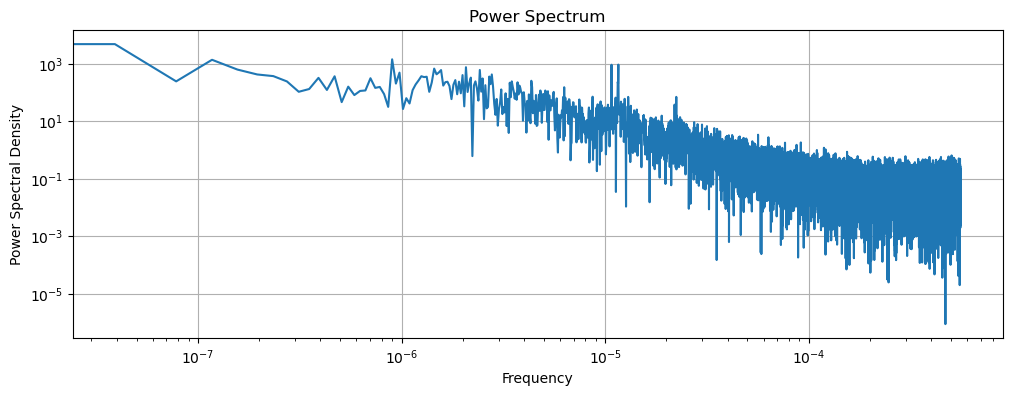

In [58]:
# Compute the PSD
psd = xrft.power_spectrum(east, dim='time')

# Plot the PSD
plt.figure(figsize=(12, 4))
plt.loglog(psd.freq_time, psd)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectrum')
plt.grid(True)
plt.show()

## using my functions

In [138]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy import stats
from scipy import signal
from numpy.fft import fft, ifft
from numpy import genfromtxt
from scipy.stats import binned_statistic

def hanning(data,N):
    """
    Create a hanning window filter
    
    Inputs: data - an array (1D timeseries or spatial data),
            N - length of data
    
    Output: data - data array with hanning window applied 
    """
    
    win = np.hanning(N)
    win = np.sqrt(N/(win**2).sum())*win     #why do we have to do this step? 
    data *= win
    
    return data

def calc_freq(N,dt):
    """
    Calculate the frequency of a given dataset
    
    Input: N - number of data points (length of dataset)
           dt - resolution of dataset 
           
    Output: freq - calculated frequency
            scale - scaling factor for frequency
    """
    
    # figure out if data length is even or odd
    # %2 gives you remainder (i.e. if N%2 = 0 then N is even)
    if N%2:
        even = False
    else:
        even = True
        
    # define scaling factor 
    scale = 1/(N*dt)
    
    # get frequency 
    if even:
        freq = np.arange(N/2+1) * scale
    else:
        freq = np.arange((N-1)/2 +1) * scale
        
    return freq, scale

def calc_spectrum(data,scale,N):
    """
    Calculate spectrum using FFT 
    
    Input: data - 1D timeseries or spatial data,
           scale - scaling factor (1/(N*dt))
           N - number of data points (length of data series)
           
    Output: spec - calculated spectrum 
    """
    # calculate FFT of dataset 
    fh = np.fft.rfft(data)
    
    # get spectrum by taking the real part of FFT 
    spec = 2*(fh*fh.conj()).real / scale / N**2
    
    # account for zeroth frequency 
    spec[0] = spec[0]/2
    
    if N%2:
        spec[-1] = spec[-1]/2
        
    return spec
    
    
def spec_var(scale,spec):
    """
    Calculate the variance of the spectrum 
    
    Input: scale - (1/(N*dt))
           spec - spectrum 
           
    Output: spec_var - spectrum variance
    
    """
    
    spec_var = scale*spec[1:].sum()
    
    return spec_var

def get_spectrum(dataset,dt,window=False):
    """
    Calculate the spectrum of a 1D timeseries / spatial series using FFT 
    
    Input: dataset - 1D data series (by time or distance)
    Output: freq - The frequency of the dataset,
            spec - spectrum of the dataset 
    """
    
    data = dataset.copy()
    data = signal.detrend(data)
    
    N = len(data)

    if window == True:
        data = hanning(data,N)
    
    freq,scale = calc_freq(N,dt)
    
    spec = calc_spectrum(data,scale,N)
    
    return freq, spec

In [141]:
freq,spec = get_spectrum(east,15,window=True)

(0.0006, 0.0008)

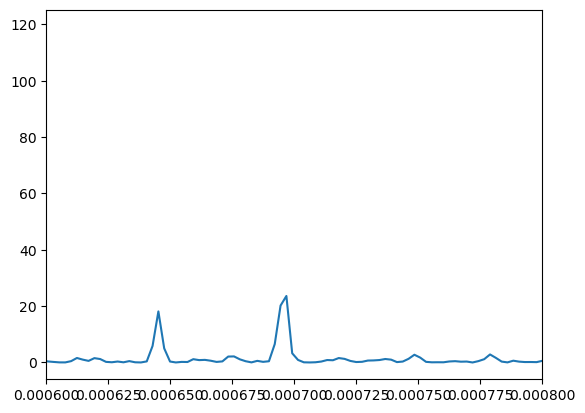

In [146]:
plt.plot(freq,spec)
plt.xlim(0.0006,0.0008)

### starting from scratch with numpy functions 

In [171]:
# step 1: ensure data is even 
# step 2: detrend the data 
tnbd_vel1100.east

<xarray.DataArray 'east' (time: 28610)>
array([-0.045259, -0.057418, -0.051127, ...,  0.025054,  0.026586,  0.024236])
Coordinates:
    index    (time) int64 ...
  * time     (time) datetime64[ns] 2018-03-13 ... 2019-01-04T23:59:54

In [173]:
u_detrend = scipy.signal.detrend(tnbd_vel1100.east)

In [174]:
np.fft.rfft(u_detrend)

array([-2.35367281e-13 +0.j        ,  3.70118907e+02-23.07828399j,
       -8.74646875e+01+59.77913946j, ...,  2.03851481e-01 -0.23980061j,
        1.54813531e+00 +0.56291179j, -7.33941656e-01 +0.j        ])

In [196]:
subset = tnbd_vel1100.east.sel(time=slice('2018-03','2019-01-02'))

In [197]:
subset

<xarray.DataArray 'east' (time: 28416)>
array([-0.045259, -0.057418, -0.051127, ...,  0.033375,  0.03174 ,  0.022429])
Coordinates:
    index    (time) int64 ...
  * time     (time) datetime64[ns] 2018-03-13 ... 2019-01-02T23:45:00

In [198]:
time_strings = subset.time.values

In [199]:
time_strings

array(['2018-03-13T00:00:00.000000000', '2018-03-13T00:15:00.000000000',
       '2018-03-13T00:30:00.000000000', ...,
       '2019-01-02T23:15:00.000000000', '2019-01-02T23:30:00.000000000',
       '2019-01-02T23:45:00.000000000'], dtype='datetime64[ns]')

In [200]:
T = (time_strings[-1] - time_strings[0]).astype('timedelta64[m]')

In [201]:
T

numpy.timedelta64(426225,'m')

In [202]:
T = 426225  #minutes 

In [203]:
delta_t = 15   # minutes 

In [206]:
sample_intervals = T/delta_t

In [207]:
sample_intervals

28415.0

In [208]:
# sample points 
N = sample_intervals + 1 

In [209]:
N

28416.0

In [213]:
nyquist_freq = 1/(2*delta_t)

In [214]:
nyquist_freq

0.03333333333333333

In [212]:
(sample_intervals/2)/(sample_intervals*delta_t)

0.03333333333333333

In [217]:
freq = np.fft.fftfreq(n=len(subset),d=1/15)

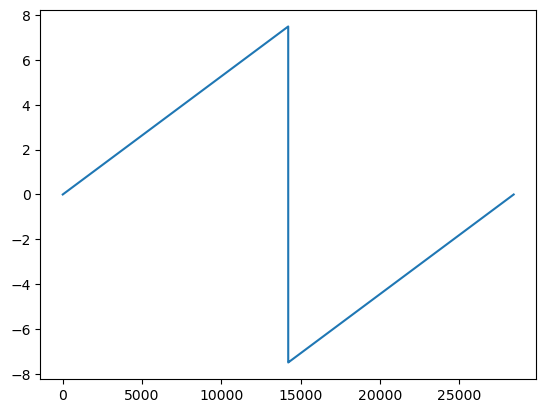

In [218]:
plt.plot(freq)

In [222]:
subset

<xarray.DataArray 'east' (time: 28416)>
array([-0.045259, -0.057418, -0.051127, ...,  0.033375,  0.03174 ,  0.022429])
Coordinates:
    index    (time) int64 ...
  * time     (time) datetime64[ns] 2018-03-13 ... 2019-01-02T23:45:00

In [55]:
freq, spec = scipy.signal.periodogram(east_detrend,1/15,detrend='linear')

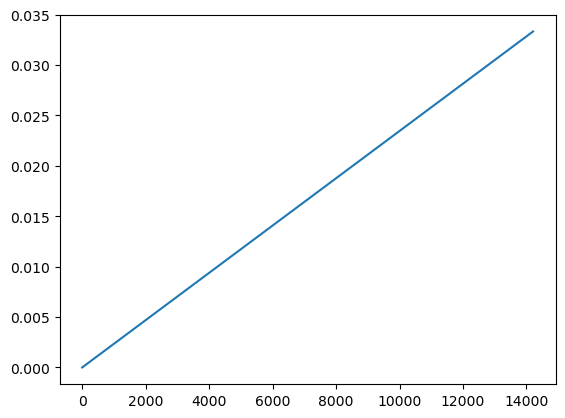

In [60]:
plt.plot(freq)

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

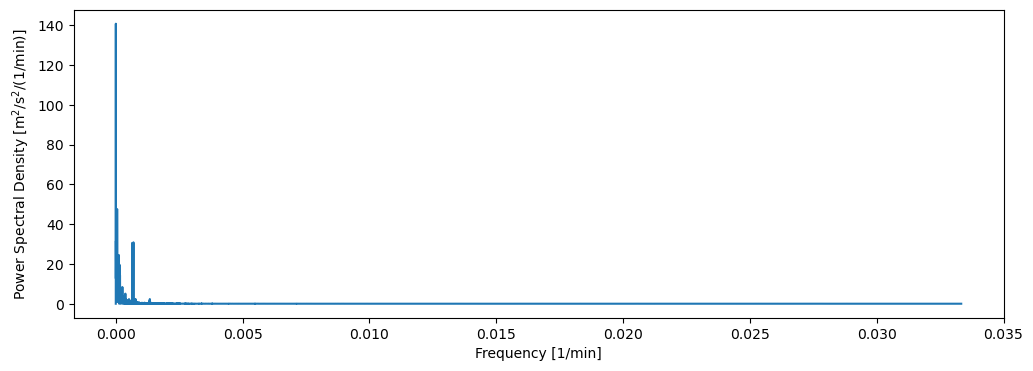

In [56]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

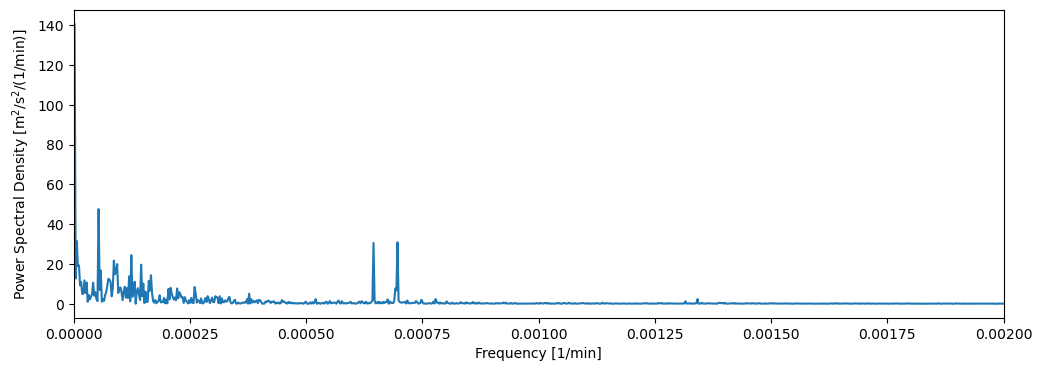

In [57]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlim(0,0.002)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
# wavelet transform 

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

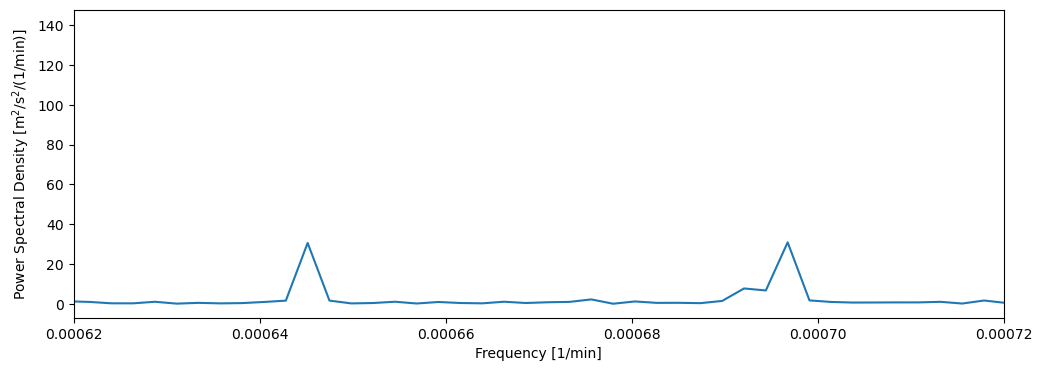

In [58]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlim(0.00062,0.00072)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

(0.0, 20.0)

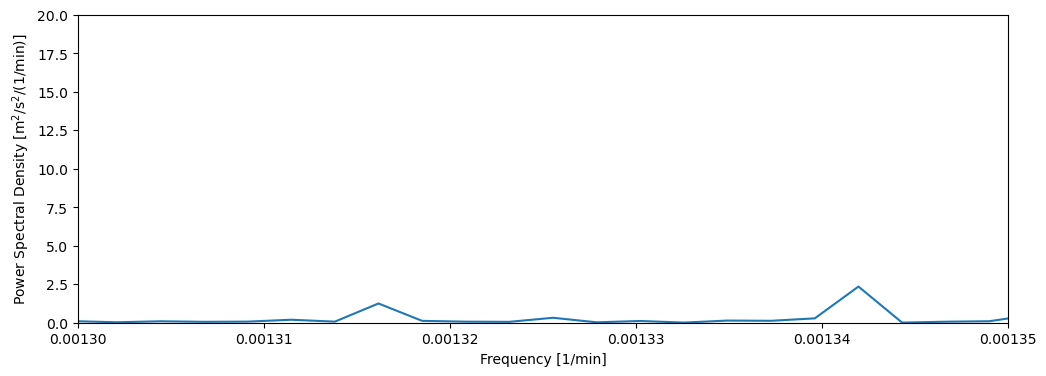

In [59]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlim(0.00130,0.00135)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
plt.ylim(0,20)

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

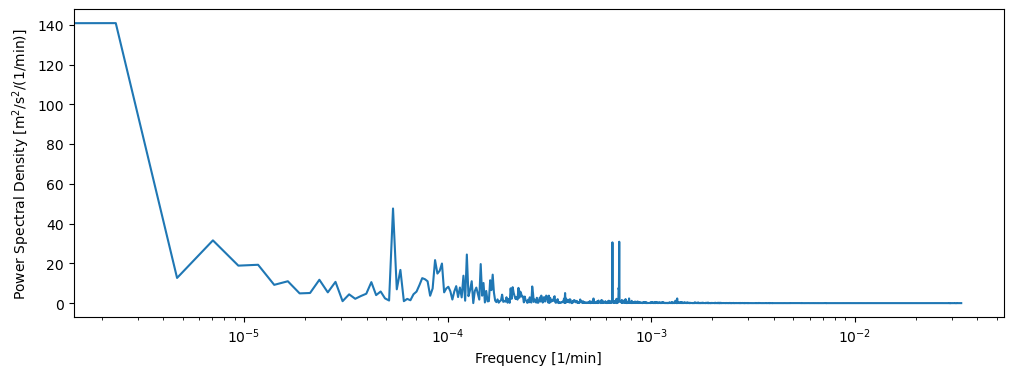

In [236]:
fig = plt.figure(figsize=(12,4))
plt.semilogx(freq,spec)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
# plt.ylim(10e-8,10e2)

(1e-07, 1000.0)

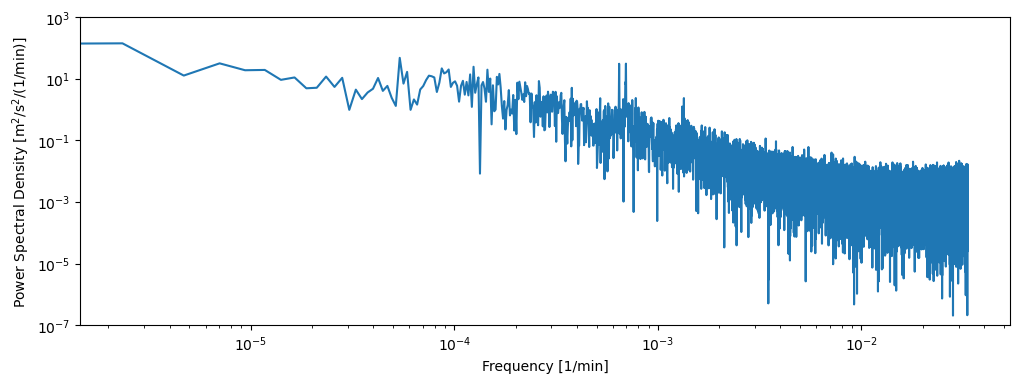

In [235]:
fig = plt.figure(figsize=(12,4))
plt.loglog(freq,spec)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
plt.ylim(10e-8,10e2)

In [254]:
subset.values

array([-0.04525864, -0.05741761, -0.05112662, ...,  0.03337533,
        0.03173989,  0.02242879])

In [287]:
fft = scipy.fft.fft(subset.values,n=len(subset))

In [288]:
fft 

array([-346.95900729  -0.j        ,  364.40628822-131.08324127j,
        -86.18297815 +14.46482818j, ...,   49.72933276+201.0152511j ,
        -86.18297815 -14.46482818j,  364.40628822+131.08324127j])

In [289]:
len(fft)

28416

In [290]:
fft_real = fft.conj().real

In [291]:
len(fft_real)

28416

In [292]:
len(fft_real[fft_real>0])

13862

In [279]:
fft_real_positive = fft_real[np.where(fft_real >= 0)]

In [280]:
len(fft_real_positive)

13862

In [264]:
fft_freq = scipy.fft.fftfreq(n=len(subset),d=1/15)

In [277]:
len(fft_freq)

28416

In [281]:
fft_freq_positive = fft_freq[np.where(fft_freq >= 0)]

In [286]:
len(fft_freq[fft_freq>0])

14207

In [282]:
len(fft_freq_positive)

14208

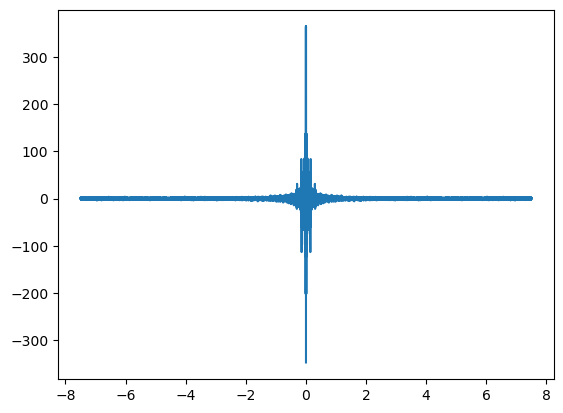

In [293]:
plt.plot(fft_freq,fft_real)